In [1]:
import duckdb
import pandas as pd

# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [2]:
%%sql success_fail << 
SELECT 
    ValueInt as count, 
    Attributes['path'][1] as path, 
    Attributes['result'][1] as result,
    Attributes['method'][1] as method
    
FROM 'metrics.parquet' 
WHERE
    Name = 'goose_requests_total'
    AND Attributes['mode'][1] = 'manager'

In [4]:
pivoted = success_fail.pivot(index=['path','method'], columns=['result'], values='count')

ratios = pivoted.apply(lambda r: {'Percentage of Successful Requests': 100.0 * r.success / (r.success + r.fail)}, axis=1, result_type='expand').rename_axis(['path','method']).reset_index()
ratios

,path,method,Percentage of Successful Requests
0,get_large_model,GET,100.0
1,get_small_model,GET,100.0
2,setup,POST,100.0
3,update_large_model,GET,100.0
4,update_large_model,POST,100.0
5,update_small_model,GET,100.0
6,update_small_model,POST,100.0


In [5]:
%%sql percentiles <<
SELECT 
    ValueDouble as duration, 
    Attributes['path'][1] as path,
    Attributes['percentile'][1] as percentile,
    Attributes['method'][1] as method
FROM './metrics.parquet' 
WHERE 
    Name = 'goose_requests_duration_percentiles' 
    AND Attributes['mode'][1] = 'manager' 
ORDER BY percentile

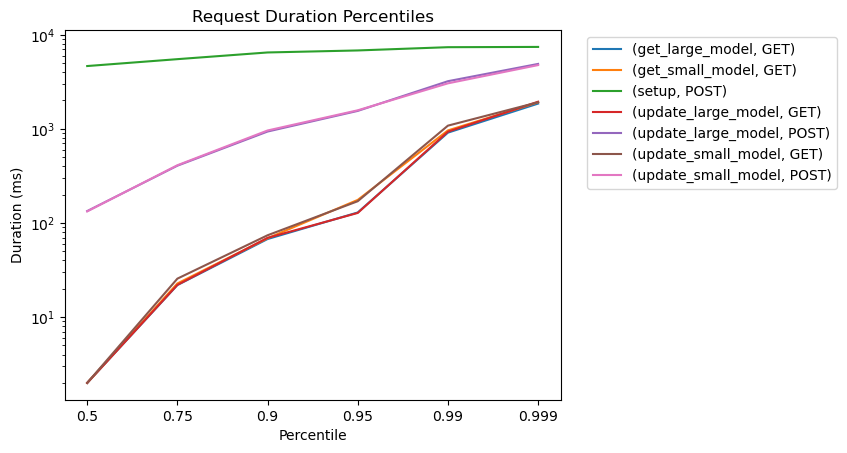

In [8]:
from matplotlib import pyplot as plt


_, ax = plt.subplots()

for label, df in percentiles.groupby(['path','method']):
    df.plot(
        x='percentile',
        y='duration',
        label=label,
        legend=True,
        logy=True,
        ax=ax,
    )

plt.title('Request Duration Percentiles')
plt.xlabel('Percentile')
plt.ylabel('Duration (ms)')
plt.legend(bbox_to_anchor=(1.04, 1))